In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('./../data/preprocessed_matches.csv')
df.head()
df = df.rename(columns={'winner': 'winner_label', 'outcome': 'outcome_label'}) if 'winner' in df.columns else df
label_map = {'H_or_D': 0, 'A': 1}

In [3]:
features = [
    'elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
    'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
    'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
    'rest_days_home', 'rest_days_away', 'rest_days_diff',
    'h2h_avg_points_home', 'h2h_avg_points_away'
]

In [4]:
train_seasons = list(range(df['season'].min(), 2023))
test_seasons = list(range(2023, df['season'].max() + 1))
train_seasons, test_seasons

([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], [2023, 2024, 2025])

In [5]:
train_df = df[df['season'].isin(train_seasons)].copy()
train_df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
0,803169,2015,2015-08-08 12:45:00,Manchester United,1,1,Tottenham Hotspur,6,0,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
1,803170,2015,2015-08-08 15:00:00,Everton,11,2,Watford,57,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
2,803162,2015,2015-08-08 15:00:00,Bournemouth,91,0,Aston Villa,7,1,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
3,803163,2015,2015-08-08 15:00:00,Norwich City,45,1,Crystal Palace,31,3,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
4,803167,2015,2015-08-08 15:00:00,Leicester City,13,4,Sunderland,56,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0


In [6]:
test_df = df[df['season'].isin(test_seasons)].copy()
test_df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
3040,2367538,2023,2023-08-11 20:00:00,Burnley,90,0,Manchester City,43,3,A,...,0.8,1.4,0.6,2.0,0.083333,2.833333,446.166667,75.145833,371.020833,1
3041,2367540,2023,2023-08-12 13:00:00,Arsenal,3,2,Nottingham Forest,17,1,H_or_D,...,1.8,1.8,1.6,1.6,1.500000,1.500000,75.854167,75.854167,0.000000,0
3042,2367541,2023,2023-08-12 15:00:00,Brighton and Hove Albion,36,4,Luton Town,102,1,H_or_D,...,1.4,1.5,1.5,1.5,1.000000,1.000000,75.937500,7.000000,68.937500,0
3043,2367542,2023,2023-08-12 15:00:00,Everton,11,0,Fulham,54,1,A,...,1.6,2.0,1.6,1.4,1.166667,1.666667,75.937500,75.937500,0.000000,1
3044,2367539,2023,2023-08-12 15:00:00,Bournemouth,91,1,West Ham United,21,1,H_or_D,...,0.6,1.0,1.6,1.2,1.250000,1.500000,75.937500,75.937500,0.000000,0


In [7]:
x_train = train_df[features]
y_train = train_df['target']

x_test = test_df[features]
y_test = test_df['target']

In [8]:
from notebooks.evaluator import evaluate
import lightgbm as lgb


def predict_lightgbm():
    params = {
        'objective': 'multiclassova',
        'num_class': 2,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }
    lgb_tr = lgb.Dataset(x_train, label=y_train)
    gbm = lgb.train(params, lgb_tr, num_boost_round=1000)
    model = gbm

    preds = model.predict(x_test)
    pred_labels = np.argmax(preds, axis=1)
    evaluate(y_test, preds, pred_labels, test_df, label_map, features, model.feature_importance(importance_type='gain'))

logloss: 0.8185279208501565
accuracy: 0.6847710330138446
Confusion matrix (rows true, cols pred):
[[522 107]
 [189 121]]
Precision: 0.6324394847879191
Recall: 0.6101056464434074


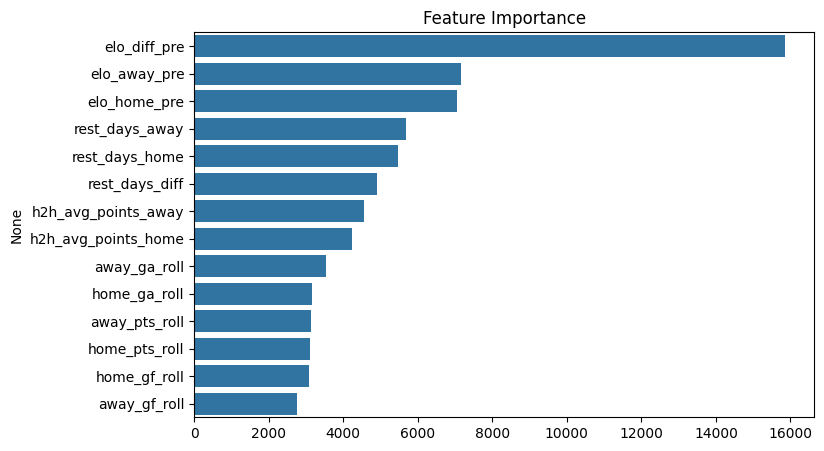

In [9]:
predict_lightgbm()

In [11]:
from xgboost import XGBClassifier


def predict_xgboost():
    xgb_model = XGBClassifier(
        n_estimators=5,
        num_class=2,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='multi:softprob',  # for multiclass probability output
        eval_metric='mlogloss'  # multi-class log loss
    )

    # Fit model
    xgb_model.fit(x_train, y_train)

    # Predict probabilities
    prob = xgb_model.predict_proba(x_test)
    pred_labels = np.argmax(prob, axis=1)
    feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

    # Evaluate model
    evaluate(y_test, prob, pred_labels, test_df, label_map, features, feature_importances)

In [9]:
# predict_xgboost()

In [8]:
df = df[df['season'] != 2015]
df['season'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [9]:
import wandb

wandb.login()

/Users/philipbaumann/Projects/epl-match-outcome-predictor/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/philipbaumann/Projects/epl-match-outcome-predictor/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annota

True

In [10]:
features_subsets = [
    ['elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
     'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'rest_days_home', 'rest_days_away', 'rest_days_diff',
     'h2h_avg_points_home', 'h2h_avg_points_away'],

    ['elo_home_pre', 'elo_away_pre', 'elo_diff_pre'],
    ['elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
     'h2h_avg_points_home', 'h2h_avg_points_away'],
    ['elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
     'rest_days_home', 'rest_days_away', 'rest_days_diff'],
    ['elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
     'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll'],
    ['elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
     'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'rest_days_home', 'rest_days_away', 'rest_days_diff'],

    ['home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll'],
    ['home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'rest_days_home', 'rest_days_away', 'rest_days_diff'],
    ['home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'h2h_avg_points_home', 'h2h_avg_points_away'],
    ['home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'rest_days_home', 'rest_days_away', 'rest_days_diff',
     'h2h_avg_points_home', 'h2h_avg_points_away'],

    ['rest_days_home', 'rest_days_away', 'rest_days_diff'],
    ['rest_days_home', 'rest_days_away', 'rest_days_diff',
     'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'h2h_avg_points_home', 'h2h_avg_points_away'],
    ['rest_days_home', 'rest_days_away', 'rest_days_diff',
     'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
     'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
     'elo_home_pre', 'elo_away_pre', 'elo_diff_pre'
     ],
    ['h2h_avg_points_home', 'h2h_avg_points_away']
]
sweep_config = {
    "method": "grid",
    "parameters": {
        "n_estimators": {"values": [50, 100, 200, 500]},
        "max_depth": {"values": [None, 50, 100, 200, 500]}
    }
}

In [10]:
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

def train_wrapper(feature_subset):
    def train():
        seasons = df["season"].unique()
        fold_accuracy = []
        fold_logloss = []
        fold_precision = []
        fold_recall = []

        run = wandb.init()
        config = run.config
        run.name = (
            f"rf_"
            f"n{config.n_estimators}_"
            f"md{config.max_depth if config.max_depth is not None else 'None'}"
        )

        model = RandomForestClassifier(
            n_estimators=config.n_estimators,
            max_depth=config.max_depth,
            random_state=42,
            class_weight='balanced',
        )

        for i in range(1, len(seasons)):
            train_seasons = seasons[:i]
            test_seasons = [seasons[i]]

            train_df = df[df["season"].isin(train_seasons)]
            test_df = df[df["season"].isin(test_seasons)]

            X_train = train_df[feature_subset]
            y_train = train_df['target']
            X_test = test_df[feature_subset]
            y_test = test_df['target']

            model.fit(X_train, y_train)

            preds = model.predict(X_test)

            prob = model.predict_proba(X_test)
            pred_labels = np.argmax(prob, axis=1)

            fold_accuracy.append(accuracy_score(y_test, preds))
            fold_logloss.append(log_loss(y_test, prob))
            fold_precision.append(precision_score(y_test, pred_labels, average='macro'))
            fold_recall.append(recall_score(y_test, pred_labels, average='macro'))

        wandb.log({
            "accuracy": np.mean(fold_accuracy),
            "logloss": np.mean(fold_logloss),
            "precision": np.mean(fold_precision),
            "recall": np.mean(fold_recall),
        })

        wandb.finish()

    return train



In [ ]:
import hashlib

tracker = {}

for feature in features_subsets:
    short = hashlib.sha1(feature.__str__().encode()).hexdigest()[:8]
    tracker[short] = feature
    sweep_id = wandb.sweep(sweep_config, project=f"rf-model-7-{short}")
    wandb.agent(sweep_id, function=train_wrapper(feature), count=20)


In [16]:
tracker["37f16e03"]

['elo_home_pre',
 'elo_away_pre',
 'elo_diff_pre',
 'home_gf_roll',
 'home_ga_roll',
 'home_pts_roll',
 'away_gf_roll',
 'away_ga_roll',
 'away_pts_roll',
 'rest_days_home',
 'rest_days_away',
 'rest_days_diff',
 'h2h_avg_points_home',
 'h2h_avg_points_away']

In [11]:
sweep_config = {
    "method": "bayes",   # besser als random für LogLoss
    "metric": {
        "name": "logloss",
        "goal": "minimize"
    },
    "parameters": {

        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 0.01,
            "max": 0.1
        },

        "num_leaves": {
            "values": [15, 31, 63, 127]
        },

        "min_data_in_leaf": {
            "values": [10, 20, 50, 100]
        },

        "feature_fraction": {
            "values": [0.7, 0.8, 0.9, 1.0]
        },

        "bagging_fraction": {
            "values": [0.7, 0.8, 0.9, 1.0]
        },

        "bagging_freq": {
            "values": [0, 5, 10]
        }
    }
}


In [16]:
def train_wrapper_lightgbm(feature_subset):
    def train():
        seasons = df["season"].unique()
        fold_accuracy = []
        fold_logloss = []
        fold_precision = []
        fold_recall = []

        run = wandb.init()
        config = run.config
        run.name = (
            f"lightgbm_lr-{config.learning_rate}_nl-{config.num_leaves}_mdil-{config.min_data_in_leaf}_fr-{config.feature_fraction}_bfg-{config.bagging_fraction}_bagging_freq-{config.bagging_freq}"
        )

        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "seed": 42,
            "learning_rate": config.learning_rate,
            "num_leaves": config.num_leaves,
            "min_data_in_leaf": config.min_data_in_leaf,
            "feature_fraction": config.feature_fraction,
            "bagging_fraction": config.bagging_fraction,
            "bagging_freq": config.bagging_freq,
        }

        for i in range(1, len(seasons)):
            train_seasons = seasons[:i]
            test_seasons = [seasons[i]]

            train_df = df[df["season"].isin(train_seasons)]
            test_df = df[df["season"].isin(test_seasons)]

            X_train = train_df[feature_subset]
            y_train = train_df['target']
            X_test = test_df[feature_subset]
            y_test = test_df['target']

            lgb_tr = lgb.Dataset(X_train, label=y_train)
            model = lgb.train(params, lgb_tr, num_boost_round=1000)

            preds = model.predict(X_test)
            pred_labels = (preds >= 0.5).astype(int)

            fold_accuracy.append(accuracy_score(y_test, pred_labels))

            fold_logloss.append(log_loss(y_test, preds))

            fold_precision.append(precision_score(y_test, pred_labels, average='macro', zero_division=0))

            fold_recall.append(recall_score(y_test, pred_labels, average='macro', zero_division=0))


        wandb.log({
            "accuracy": np.mean(fold_accuracy),
            "logloss": np.mean(fold_logloss),
            "precision": np.mean(fold_precision),
            "recall": np.mean(fold_recall),
        })

        wandb.finish()

    return train



In [ ]:
import hashlib

tracker = {}

for feature in features_subsets:
    short = hashlib.sha1(feature.__str__().encode()).hexdigest()[:8]
    tracker[short] = feature
    sweep_id = wandb.sweep(sweep_config, project=f"lightgbm-model-3-{short}")
    wandb.agent(sweep_id, function=train_wrapper_lightgbm(feature), count=20)

In [25]:
tracker["b72b89f1"]

['elo_home_pre',
 'elo_away_pre',
 'elo_diff_pre',
 'home_gf_roll',
 'home_ga_roll',
 'home_pts_roll',
 'away_gf_roll',
 'away_ga_roll',
 'away_pts_roll',
 'rest_days_home',
 'rest_days_away',
 'rest_days_diff']

In [11]:
sweep_params = {
    "method": "bayes",   # besser als random für LogLoss
    "metric": {
        "name": "logloss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 0.01,
            "max": 0.2
        },

        "n_estimators": {
            "values": [100, 200, 400, 800]
        },

        "max_depth": {
            "values": [3, 4, 5, 6, 8]
        },

        "min_child_weight": {
            "values": [1, 5, 10, 20]
        },

        "subsample": {
            "values": [0.6, 0.8, 1.0]
        },

        "colsample_bytree": {
            "values": [0.6, 0.8, 1.0]
        },
    }


}


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score

def train_wrapper_xgboost(feature_subset):
    def train():
        seasons = df["season"].unique()
        fold_accuracy = []
        fold_logloss = []
        fold_precision = []
        fold_recall = []

        run = wandb.init()
        config = run.config
        run.name = (
            f"xgbclassifier_lr-{config.learning_rate}_n-{config.n_estimators}md-{config.max_depth}_mcw-{config.min_child_weight}_sub-{config.subsample}_cb-{config.colsample_bytree}"
        )

        xgb_model = XGBClassifier(
            n_estimators=config.n_estimators,
            max_depth=config.max_depth,
            learning_rate=config.learning_rate,
            subsample=config.subsample,
            colsample_bytree=config.colsample_bytree,
            random_state=42,
            objective="binary:logistic",
            eval_metric="logloss"
        )

        for i in range(1, len(seasons)):
            train_seasons = seasons[:i]
            test_seasons = [seasons[i]]

            train_df = df[df["season"].isin(train_seasons)]
            test_df = df[df["season"].isin(test_seasons)]

            X_train = train_df[feature_subset]
            y_train = train_df['target']
            X_test = test_df[feature_subset]
            y_test = test_df['target']

            # Fit model
            xgb_model.fit(X_train, y_train)

            # Predict probabilities
            prob = xgb_model.predict_proba(X_test)[:, 1]
            pred_labels = (prob >= 0.5).astype(int)

            fold_accuracy.append(accuracy_score(y_test, pred_labels))

            fold_logloss.append(log_loss(y_test, prob))

            fold_precision.append(precision_score(y_test, pred_labels, zero_division=0))

            fold_recall.append(recall_score(y_test, pred_labels, zero_division=0))


        wandb.log({
            "accuracy": np.mean(fold_accuracy),
            "logloss": np.mean(fold_logloss),
            "precision": np.mean(fold_precision),
            "recall": np.mean(fold_recall),
        })

        wandb.finish()

    return train



In [ ]:
import hashlib

tracker = {}

for feature in features_subsets:
    short = hashlib.sha1(feature.__str__().encode()).hexdigest()[:8]
    tracker[short] = feature
    sweep_id = wandb.sweep(sweep_params, project=f"xgboost-model-1-{short}")
    wandb.agent(sweep_id, function=train_wrapper_xgboost(feature), count=20)

Create sweep with ID: 3q293sv6
Sweep URL: https://wandb.ai/philip-baumann-hslu/xgboost-model-1-37f16e03/sweeps/3q293sv6


wandb: Agent Starting Run: qmnhnukn with config:
wandb: 	colsample_bytree: 0.8
wandb: 	learning_rate: 0.197710350121687
wandb: 	max_depth: 8
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 800
wandb: 	subsample: 0.6


[08:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.6771
logloss,1.07956
precision,0.50465
recall,0.36461


wandb: Agent Starting Run: yz7l7kjy with config:
wandb: 	colsample_bytree: 0.6
wandb: 	learning_rate: 0.060748563886748395
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 400
wandb: 	subsample: 1


[08:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.68892
logloss,0.75442
precision,0.52907
recall,0.37928


wandb: Agent Starting Run: wgnk6cho with config:
wandb: 	colsample_bytree: 0.6
wandb: 	learning_rate: 0.05769833786109782
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 400
wandb: 	subsample: 1


[08:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.69611
logloss,0.61944
precision,0.55282
recall,0.37235


wandb: Agent Starting Run: g1c1oqfb with config:
wandb: 	colsample_bytree: 1
wandb: 	learning_rate: 0.19965271079239053
wandb: 	max_depth: 5
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 100
wandb: 	subsample: 0.8


[08:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.68232
logloss,0.70672
precision,0.51603
recall,0.37639


wandb: Agent Starting Run: w0ohu6v7 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	learning_rate: 0.03504704994695317
wandb: 	max_depth: 5
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 400
wandb: 	subsample: 0.8


[08:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.69666
logloss,0.64285
precision,0.54968
recall,0.38283


wandb: Agent Starting Run: 31pf8su0 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	learning_rate: 0.032935030218878496
wandb: 	max_depth: 5
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 400
wandb: 	subsample: 1


[08:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.69103
logloss,0.63245
precision,0.53816
recall,0.37654


wandb: Agent Starting Run: yrhbqt3u with config:
wandb: 	colsample_bytree: 0.8
wandb: 	learning_rate: 0.022278145247546236
wandb: 	max_depth: 3
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	subsample: 1


[08:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.70839
logloss,0.57024
precision,0.5816
recall,0.3786


wandb: Agent Starting Run: zyyi91fl with config:
wandb: 	colsample_bytree: 1
wandb: 	learning_rate: 0.021746734864709145
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 200
wandb: 	subsample: 1


[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.70894
logloss,0.57055
precision,0.58098
recall,0.38265


wandb: Agent Starting Run: xmq6ib7p with config:
wandb: 	colsample_bytree: 0.8
wandb: 	learning_rate: 0.017455473894670788
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 200
wandb: 	subsample: 0.8


[08:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.7119
logloss,0.56883
precision,0.58804
recall,0.3891


wandb: Agent Starting Run: dilegrsv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	learning_rate: 0.01171468947271889
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 100
wandb: 	subsample: 1


[08:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[08:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

accuracy,▁
logloss,▁
precision,▁
recall,▁
accuracy,0.70998
logloss,0.56995
precision,0.63486
recall,0.26521
